## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os

from moviepy.editor import VideoFileClip

# Plot in a new window
%matplotlib qt

In [3]:
board_width = 9
board_height = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((board_width*board_height,3), np.float32)
objp[:,:2] = np.mgrid[0:board_width,0:board_height].T.reshape(-1,2) # x, y corrdinates

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Create output calibration path
output_path = 'camera_cal_output/'

try:
    if not os.path.exists(output_path):
        os.mkdir(output_path)
except OSError:  
    print ("Creation of the directory %s failed" % output_path)

image_shape = (0,0)
    
# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    image_shape = img.shape[1::-1]
    file_name = fname[fname.rfind('/') + 1:]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (board_width, board_height), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (board_width, board_height), corners, ret)
        plt.imsave(output_path + file_name, img)

# Calibrate the camera to give 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)

**Result will be at the notebook path/camera_cal_output**

## Applying a distortion correction to raw images.

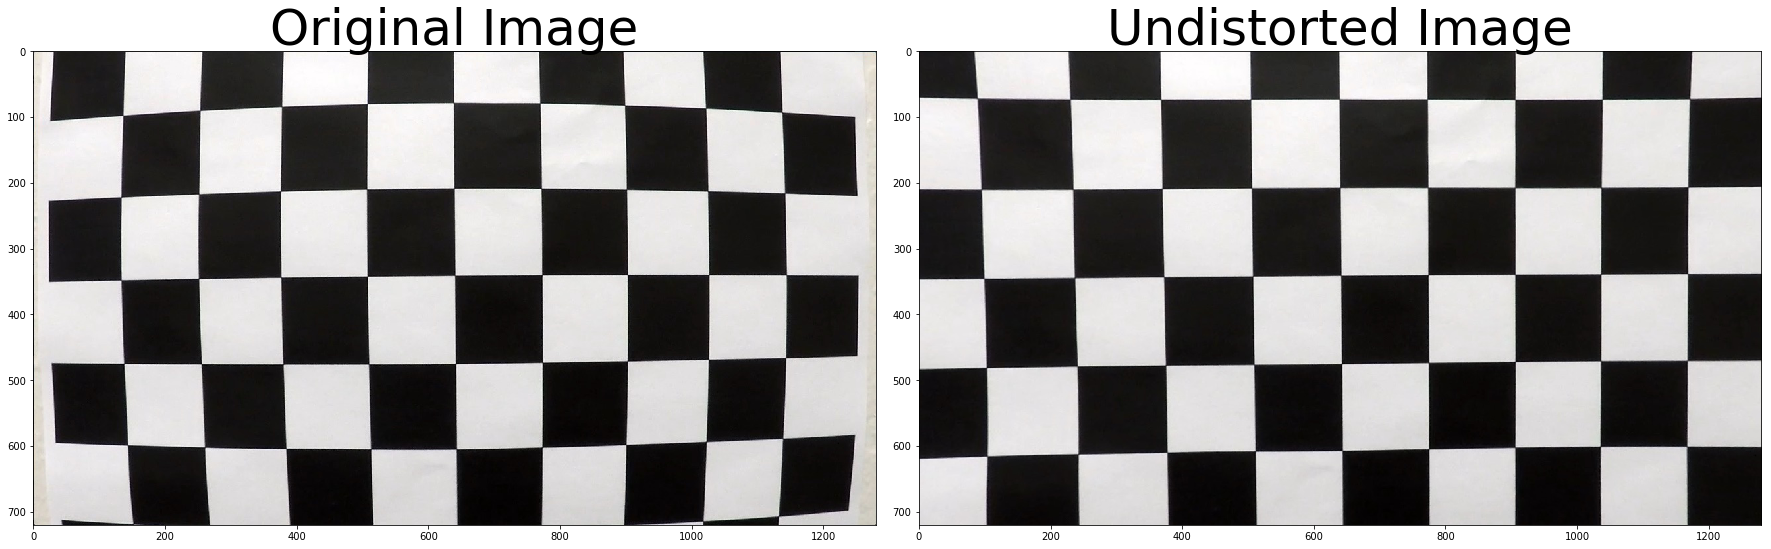

In [4]:
# Now that we have calibrated the camera let's try undistorting an image
def undistort_img(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Read in an image
img = mpimg.imread('../camera_cal/calibration1.jpg')

undistorted = undistort_img(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Create a shape graident that enhance the visibility of the lane lines. ##

### Gradient helper functions

In [5]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, sobel_thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    
    return dir_binary


### Create combined gradient

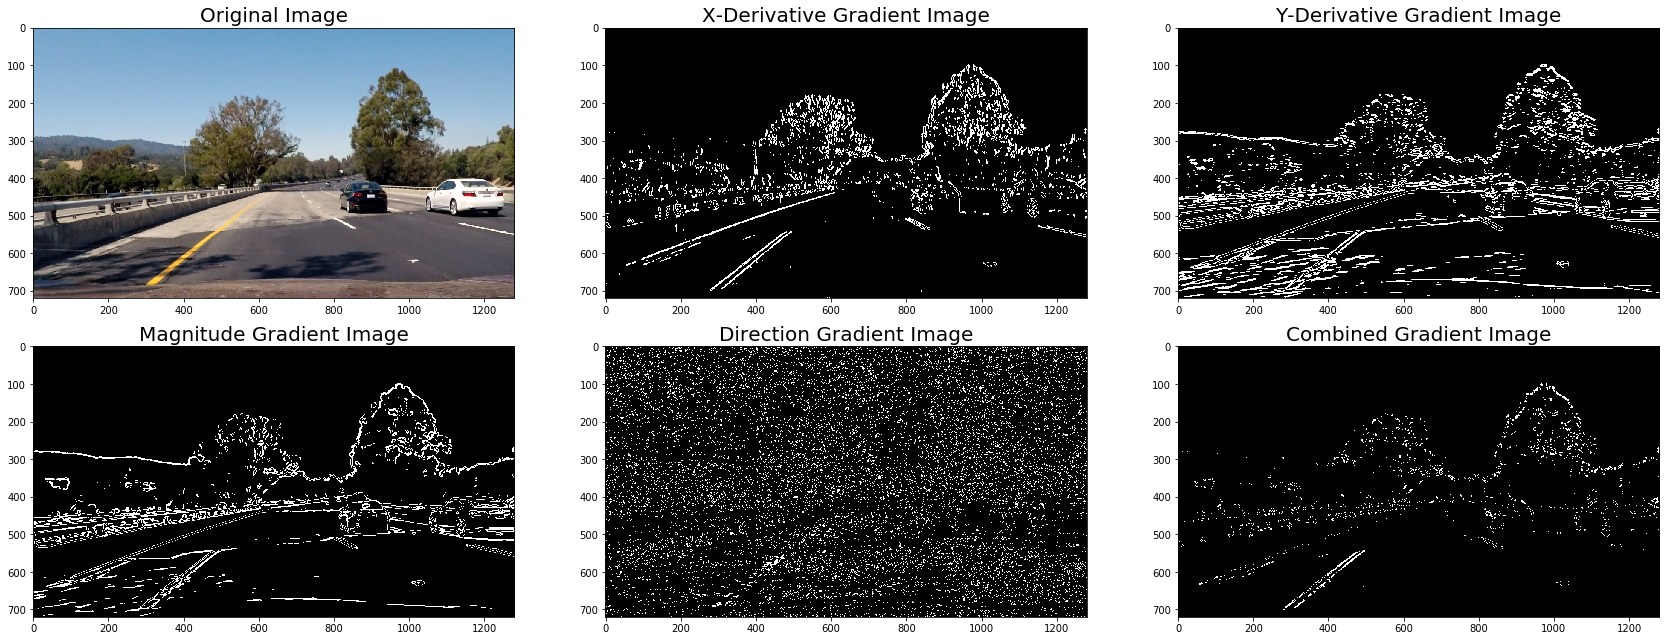

In [6]:
# Read in an image
image = mpimg.imread('../test_images/test4.jpg')

# Undistort the image
undistorted_img = undistort_img(image, objpoints, imgpoints)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

def build_shape_gradient(image, sobel_kernel):    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, sobel_thresh=(30, 80))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, sobel_thresh=(30, 80))
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, dir_thresh=(0.7, 0.9))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return (gradx, grady, mag_binary, dir_binary, combined_gradient)

gradx, grady, mag_binary, dir_binary, combined_shape_gradient = build_shape_gradient(undistorted_img, ksize)

f, axes = plt.subplots(2, 3, figsize=(24, 9))
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image', fontsize=20)

axes[0, 1].imshow(gradx, cmap='gray')
axes[0, 1].set_title('X-Derivative Gradient Image', fontsize=20)

axes[0, 2].imshow(grady, cmap='gray')
axes[0, 2].set_title('Y-Derivative Gradient Image', fontsize=20)

axes[1, 0].imshow(mag_binary, cmap='gray')
axes[1, 0].set_title('Magnitude Gradient Image', fontsize=20)

axes[1, 1].imshow(dir_binary, cmap='gray')
axes[1, 1].set_title('Direction Gradient Image', fontsize=20)

axes[1, 2].imshow(combined_shape_gradient, cmap='gray')
axes[1, 2].set_title('Combined Gradient Image', fontsize=20)

f.tight_layout()

## Build a color threshold that enhance the visibility of the lane lines. ##

### Build a color threshold using the saturation from the HLS color space of an image. ###

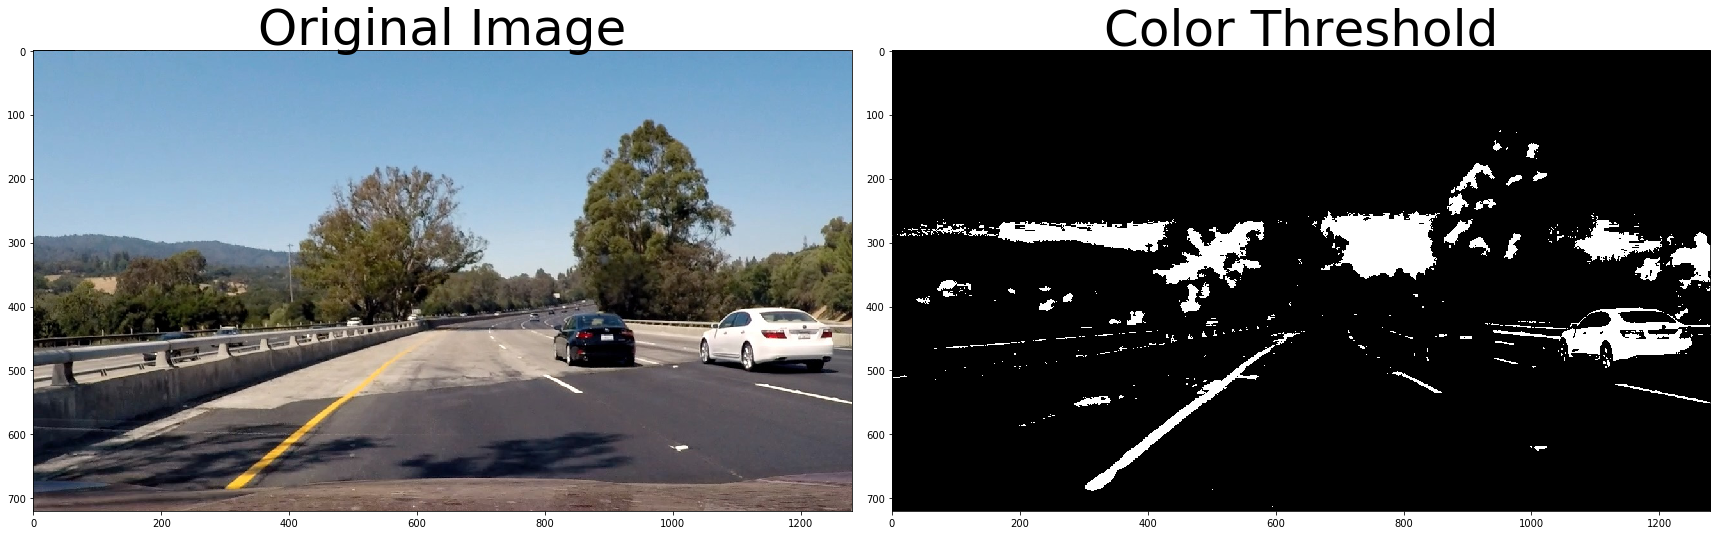

In [7]:
def build_color_threshold(img, hls_thresh=(0, 255), hsv_thresh=(0, 255), lab_thresh=(0, 255)):
    # Use HLS to get the white lines
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    
    # Use HSV to get the yellow lines
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    s = hsv[:,:,2]
    
    # Use LAB to get lines from shadow
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b = lab[:,:,2]
    
    # Return a binary image of threshold result
    color_threshold = np.zeros_like(s)
    color_threshold[
                    (l > hls_thresh[0]) & (l <= hls_thresh[1]) |
                    (s > hsv_thresh[0]) & (s <= hsv_thresh[1]) |
                    (b > lab_thresh[0]) & (b <= lab_thresh[1])
                   ] = 1
#     color_threshold[(s > hsv_thresh[0]) & (s <= hsv_thresh[1])] = 1
    return color_threshold

hls_thresh = (200, 255)
hsv_thresh = (230, 255)
lab_thresh = (150, 255)

color_threshold = build_color_threshold(undistorted_img, 
                                        hls_thresh = hls_thresh, 
                                        hsv_thresh = hsv_thresh, 
                                        lab_thresh = lab_thresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_threshold, cmap='gray')
ax2.set_title('Color Threshold', fontsize=50)
f.tight_layout()

## Now we want to combine the shape gradient and the color threshold into one binary image. ##

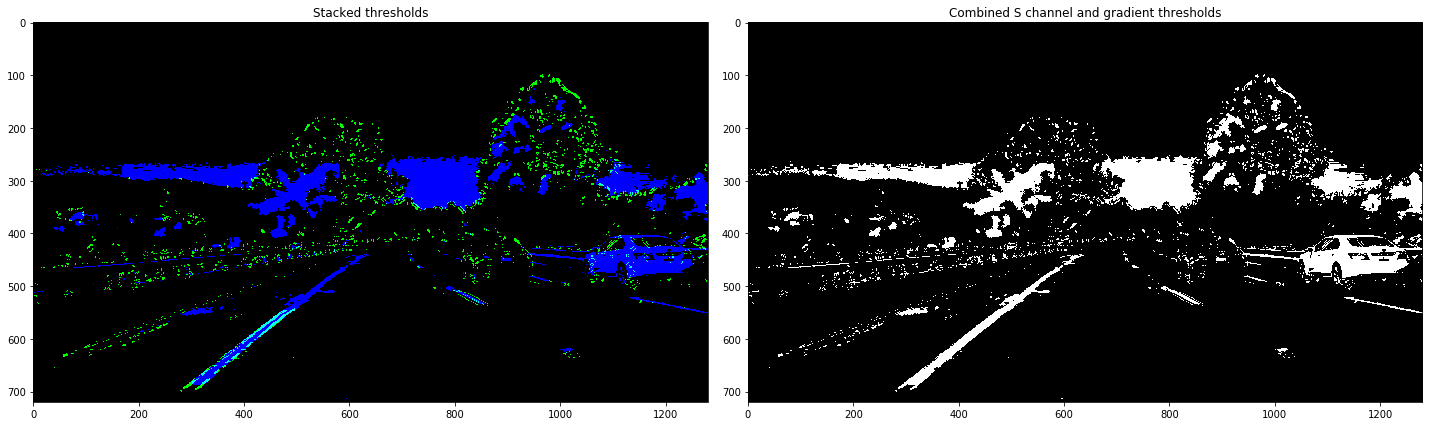

In [8]:
def build_binary_threshold(image, objpoints, imgpoints, sobel_kernel):
    shape_tuple = build_shape_gradient(image, sobel_kernel)
    combined_gradient = shape_tuple[len(shape_tuple) - 1]
    
    color_threshold = build_color_threshold(undistorted_img, 
                                        hls_thresh = hls_thresh, 
                                        hsv_thresh = hsv_thresh, 
                                        lab_thresh = lab_thresh)
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.uint8(np.dstack(( np.zeros_like(combined_gradient), combined_gradient, color_threshold)) * 255)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined_gradient)
    combined_binary[(color_threshold == 1) | (combined_gradient == 1)] = 1
    
    return (combined_gradient, color_binary, combined_binary)
    
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
f.tight_layout()

## Build a perspective transform ##

(580, 440)
(99.99999999999743, 10.00000000000169)
(700, 440)
(1180.00000000002, 10.000000000008557)
(1230, 720)
(1180.0000000000014, 710.0000000000014)
(100, 720)
(100.00000000000053, 710.0000000000006)


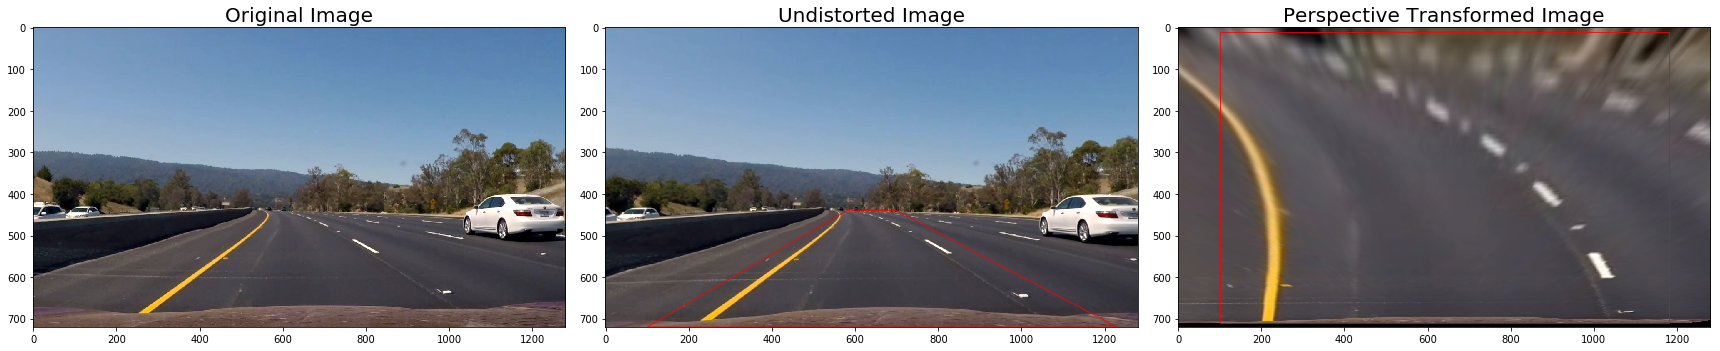

In [53]:
# Takes in an undistorted calibration image
def build_perspective_matrix(image, board_width, board_height, transform_area):
    src = np.float32(transform_area)

    top_bottom_offset = 10
    left_right_offset = 100
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[left_right_offset, top_bottom_offset],
                      [img_size[0] - left_right_offset, top_bottom_offset], 
                      [img_size[0] - left_right_offset, img_size[1] - top_bottom_offset], 
                      [left_right_offset, img_size[1] - top_bottom_offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
            
    return (M, M_inverse)

def apply_perspective_transform(image, perspective_M):
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# Read in an image
image = mpimg.imread('../test_images/trouble_image_128.jpg')

# Undistort the image
undistorted_img = undistort_img(image, objpoints, imgpoints)

img_size = (image.shape[1], image.shape[0])
area_points = [(580, 440), 
               (700, 440), 
               (img_size[0] - 50, img_size[1]), 
               (100, img_size[1])]
transform_area = [area_points]

perspective_M, perspective_M_inverse = build_perspective_matrix(undistorted_img, board_width, board_height, transform_area)
warped_image = apply_perspective_transform(undistorted_img, perspective_M)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=20)
# Create a Polygon patch
polygon = patches.Polygon(area_points, alpha=.8, fill=False, color='red')

# Add the patch to image
ax2.add_patch(polygon)

transformed_points = []

for point in area_points:
    print(point)
    result = np.dot(perspective_M, [point[0], point[1], 1])
    result = (result[0] / result[2], result[1] / result[2])
    print(result)
    
    transformed_points.append(result)

#print(transformed_points)    

ax3.imshow(warped_image)
ax3.set_title('Perspective Transformed Image', fontsize=20)
# Create a Polygon patch
polygon = patches.Polygon(transformed_points, alpha=.8, fill=False, color='red')

# Add the patch to image
ax3.add_patch(polygon)

f.tight_layout()

## Finding the lines ##

### We have the perspective transform so we can try to find the lane lines from the combined_binary ###

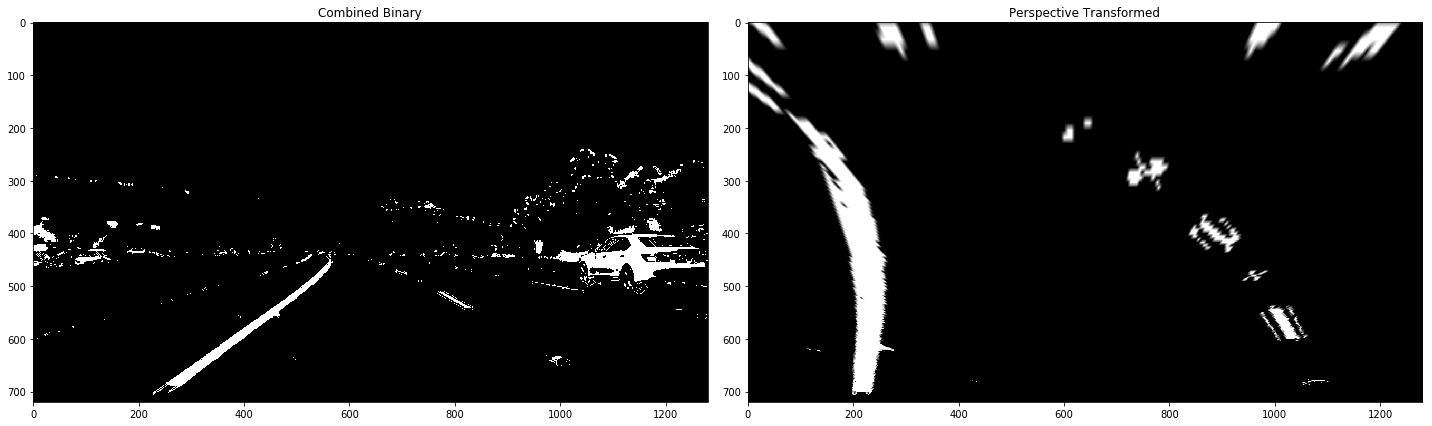

In [45]:
# Read in an image
image = mpimg.imread('../test_images/trouble_image_128.jpg')

# Undistort the image
undistorted_img = undistort_img(image, objpoints, imgpoints)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Get the combined_binary
combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)[2]

# Apply perspective transform
warped_image = apply_perspective_transform(combined_binary, perspective_M)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Combined Binary')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Perspective Transformed')
ax2.imshow(warped_image, cmap='gray')
f.tight_layout()

### We will use histogram to find the center of each lane ###

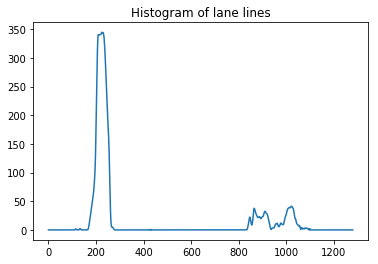

In [46]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(warped_image)

# Visualize the resulting histogram
plt.title("Histogram of lane lines")
plt.plot(histogram)

### We will are presuming that the middle of the lane is the bottom-center of the image. We split the histogram in half to detect where the start of each lane line ###

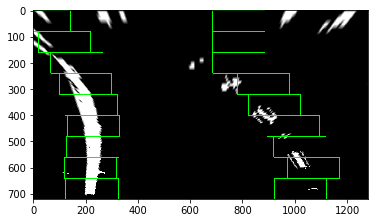

In [47]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(warped_image.shape[0]//nwindows)

def find_lane_pixels(warped_image):
    # Create histogram of image binary activations
    histogram = hist(warped_image)
    
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((warped_image, warped_image, warped_image)) * 255)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    warped_image_shape = warped_image.shape
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image_shape[0] - (window + 1) * window_height
        win_y_high = warped_image_shape[0] - window * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low, win_y_low), (win_xright_high, win_y_high),(0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recalculate the center of the boxes #
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

plt.imshow(out_img)

### Fitting a polynomial to the lane lines ###

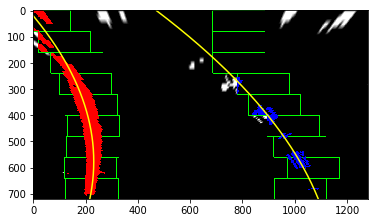

In [48]:
def fit_polynomial(warped_image):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return (left_fitx, right_fitx, out_img)


left_fitx, right_fitx, out_img = fit_polynomial(warped_image)

ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
    
plt.imshow(out_img)

## Drawing lane lines

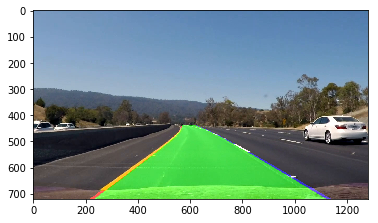

In [52]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

def draw_lane(image):
    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    # Build binary
    combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)
    
    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    # Find the lane polynomials
    left_fitx, right_fitx, out_img = fit_polynomial(warped_image)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    left_lane_coords = np.stack((left_fitx, ploty), axis=-1)
    right_lane_coords = np.stack((right_fitx, ploty), axis=-1)
    
    combined_coords = []
    
    for i in range(0, len(left_lane_coords)):
        combined_coords.append(left_lane_coords[i])
        combined_coords.append(right_lane_coords[i])
    
    # Create a canvas for us to draw on.
    image_size = warped_image.shape
    output_image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # Use fillpoly to draw the lane line
    cv2.fillPoly(output_image, np.int_([combined_coords]), (0,255, 0))
    cv2.polylines(output_image, np.int32([left_lane_coords]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(output_image, np.int32([right_lane_coords]), isClosed=False, color=(0,0,255), thickness=15)
    
    # Transform the image back to the scene
    output_image = apply_perspective_transform(output_image, perspective_M_inverse)
    
    # Combine the result with the original image
    output_image = cv2.addWeighted(output_image, 0.6, image, 1, 0)
    
    return output_image
    
# Read in an image
image = mpimg.imread('../test_images/trouble_image_128.jpg')

result = draw_lane(image)

plt.imshow(result)

## Determine the center of the lane and curvature of the road.

Done


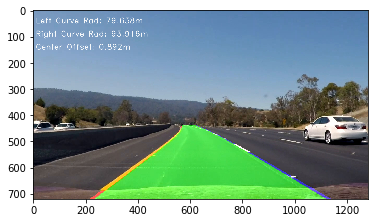

In [51]:
def calculate_road_curvature_and_center(image):
    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    # Build binary
    combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)
    
    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    # Find the lane polynomials
    left_fitx, right_fitx, out_img = fit_polynomial(warped_image)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 18 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    
    # Calculate the center
    # Find the midpoint between the first point (point closest to the car) on the fitted lanes.
    # Then subtract this from the center of the wrapped image.
    # Result:
    # < 0: Left of center
    # > 0: Right of center
    image_center = warped_image.shape[1] / 2
    lane_center = left_fitx[0] + (right_fitx[0] - left_fitx[0])
    center_offset = image_center - lane_center
    
    # Convert to meters
    center_offset *= xm_per_pix
    
    return (left_curverad, right_curverad, avg_rad, center_offset)

def draw_info(image, left_curverad, right_curverad, avg_rad, center_offset):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = "Left Curve Rad: {0}m".format(round(left_curverad, 3))
    cv2.putText(image, text,(10, 50), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    text = "Right Curve Rad: {0}m".format(round(right_curverad, 3))
    cv2.putText(image, text,(10, 100), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    text = "Center Offset: {0}m".format(round(center_offset, 3))
    cv2.putText(image, text,(10, 150), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    return image

def process_image(image):
    left_curverad, right_curverad, avg_rad, center_offset = calculate_road_curvature_and_center(image)
    result = draw_lane(image)
    result = draw_info(result, left_curverad, right_curverad, avg_rad, center_offset)
    
    return result

# Read in an image
image = mpimg.imread('../test_images/trouble_image_128.jpg')

result = process_image(image)
plt.imshow(result)
# plt.imsave('../output_images/test_images/trouble_image_128_2.jpg', result)

print("Done")


## Test with test images

In [57]:
# Make a list of calibration images
# images = glob.glob('../test_images/*.jpg')
images = glob.glob('../trouble_images/original_images/*.jpg')

# Create output calibration path
# output_path = '../output_images/test_images/'
output_path = '../trouble_images/result_images_2/'

try:
    if not os.path.exists(output_path):
        os.makedirs(output_path)
except OSError:  
    print ("Creation of the directory %s failed" % output_path)
    
for fname in images:
    image = mpimg.imread(fname)
    file_name = fname[fname.rfind('/') + 1:]
    
    result = process_image(image)
    
    plt.imsave(output_path + file_name, result)
    
print("Done")

Done


## Test with videos

In [58]:
# Create output calibration path
original_output_path = '../trouble_images/original_images/'
result_output_path = '../trouble_images/result_images/'

try:
    if not os.path.exists(original_output_path):
        os.makedirs(original_output_path)
except OSError:  
    print ("Creation of the directory %s failed" % original_output_path)
    
try:
    if not os.path.exists(result_output_path):
        os.makedirs(result_output_path)
except OSError:  
    print ("Creation of the directory %s failed" % result_output_path)

trouble_count = 1
def process_video_image(image):
    global trouble_count
    file_name = "trouble_image_{0}".format(trouble_count)
    plt.imsave(original_output_path + file_name, image)
    result = process_image(image)
    plt.imsave(result_output_path + file_name, result)
    trouble_count = trouble_count + 1

video_file_path = '../test_video_1.mp4'
video_file_output_path = '../output_test_video_1.mp4'
video_input1 = VideoFileClip(video_file_path)
# processed_video = video_input1.fl_image(process_video_image)
# %time processed_video.write_videofile(video_file_output_path, audio=False)

for frame in video_input1.iter_frames():
    try:
        process_video_image(frame)
    except:
        "Something broke"

print("Done")

Done
